# Initial problem resolution

In [1]:
using JuMP
using Gurobi
using CSV 
using DataFrames
using Random
using Plots
using Distributions

In [2]:
# Load time series data
load_data = CSV.read("county_demand_local_hourly_2014.csv", DataFrame)
solar_cf = CSV.read("cf_local_county_2014.csv", DataFrame)

# Load network data
bus_data = CSV.read("IEEE_33_bus_system.csv", DataFrame)
max_flows = CSV.read("max_flows.csv", DataFrame)


rename!(max_flows, "Line number" => "Branch No.")
network_data_match = all(eachrow(bus_data[!, ["From bus", "To bus", "Branch No."]]) .== eachrow(max_flows[!, ["From bus", "To bus", "Branch No."]]))

if network_data_match
    # Merge the data
    network_data = innerjoin(bus_data, max_flows, on=["From bus", "To bus", "Branch No."])
    println("Data merged successfully")
else
    println("Data columns do not match")
end

buses = 1:33
lines = 1:32
T = 24;

Data merged successfully


# First Paper


In [3]:
# Lossless power flow model
function create_hc_model_naive(network_data)
    model = Model(Gurobi.Optimizer)

    # Variables
    @variable(model, PG[buses] ≥ 0)  # Active power generation of PV
    @variable(model, QG[buses])  # Reactive power generation of PV
    @variable(model, -0.1 <= ΔV[buses] <= 0.1)  # Voltage magnitude deviation
    @variable(model, Δθ[buses])  # Voltage angle deviation
    @variable(model, PL[lines])  # Active power flow
    @variable(model, QL[lines])  # Reactive power flow
    @variable(model, PM)  # Active power exchange with upstream grid
    @variable(model, QM)  # Reactive power exchange with upstream grid

    # Objective function
    @objective(model, Max, sum(PG))

    # Constraints
    # Power flow equations
    for l in lines
        i, j = network_data[l, Symbol("From bus")], network_data[l, Symbol("To bus")]
        r, x = network_data[l, Symbol("R (Ω)")], network_data[l, Symbol("X (Ω)")]
        g, b = r / (r^2 + x^2), -x / (r^2 + x^2)
        @constraint(model, PL[l] == g * (1 + ΔV[i]) * (ΔV[i] - ΔV[j]) - b * (Δθ[i] - Δθ[j]))
        @constraint(model, QL[l] == -b * (1 + ΔV[i]) * (ΔV[i] - ΔV[j]) - g * (Δθ[i] - Δθ[j]))
    end

    # Power balance constraints
    for i in buses
        @constraint(model, 
            (i == 1 ? PM : 0) + 
            sum(PL[l] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(PL[l] for l in lines if network_data[l, Symbol("From bus")] == i) + 
            PG[i] == 
            sum(network_data[l, Symbol("P (kW)")] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Convert kW to MW
        )
        @constraint(model, 
            (i == 1 ? QM : 0) + 
            sum(QL[l] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(QL[l] for l in lines if network_data[l, Symbol("From bus")] == i) +
            QG[i] == 
            sum(network_data[l, Symbol("Q (kW)")] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Convert kW to MW
        )
    end

    @constraint(model, PG[1] == 0)  
    @constraint(model, QG[1] == 0)

    # Voltage and line capacity constraints
    @constraint(model, -4.6 .<= PM .<= 4.6)  # Active power exchange limits with upstream grid
    @constraint(model, -4.6 .<= QM .<= 4.6)  # Reactive power exchange limits with upstream grid
    for l in lines
        active_max_flow = network_data[l, Symbol("Maximum line capacity (active power [KW])")] / 1000  # Convert to MW
        reactive_max_flow = network_data[l, Symbol("Maximum line capacity (reactive power [KVAR])")] / 1000  # Convert to MVAR
        @constraint(model, -active_max_flow <= PL[l] <= active_max_flow)
        @constraint(model, -reactive_max_flow <= QL[l] <= reactive_max_flow)
    end

    return model
end


function main_naive()
    model = create_hc_model_naive(network_data)
    optimize!(model)

    # Store all solution values
    PG_values = Array(value.(model[:PG]))
    QG_values = Array(value.(model[:QG]))
    ΔV_values = Array(value.(model[:ΔV]))
    Δθ_values = Array(value.(model[:Δθ]))
    PL_values = Array(value.(model[:PL]))
    QL_values = Array(value.(model[:QL]))
    PM_value = value(model[:PM])
    QM_value = value(model[:QM])

    # Create dataframes to display the results
    bus_results = DataFrame(Bus = buses, PG = PG_values, QG = QG_values, ΔV = ΔV_values, Δθ = Δθ_values)
    line_results = DataFrame(Line = lines, PL = PL_values, QL = QL_values)

    # Display the results
    println("Bus Results:")
    println(bus_results)
    println("\nLine Results:")
    println(line_results)
    println("\nUpstream Grid Exchange:")
    println("PM: ", PM_value)
    println("QM: ", QM_value)

    # Print results
    println("Optimal PV capacity: ", value.(model[:PG]))
    println("Total PV capacity: ", sum(value.(model[:PG])))
end

function optimize_naive_model(network_data)
    model = create_hc_model_naive(network_data)
    optimize!(model)
    return model
end

function display_naive_results(model)
    # Store all solution values
    PG_values = Array(value.(model[:PG]))
    QG_values = Array(value.(model[:QG]))
    ΔV_values = Array(value.(model[:ΔV]))
    Δθ_values = Array(value.(model[:Δθ]))
    PL_values = Array(value.(model[:PL]))
    QL_values = Array(value.(model[:QL]))
    PM_value = value(model[:PM])
    QM_value = value(model[:QM])

    # Create dataframes to display the results
    bus_results = DataFrame(Bus = buses, PG = PG_values, QG = QG_values, ΔV = ΔV_values, Δθ = Δθ_values)
    line_results = DataFrame(Line = lines, PL = PL_values, QL = QL_values)

    # Display the results
    println("\nUpstream Grid Exchange:")
    println("PM: ", PM_value)
    println("QM: ", QM_value)
    println("Total PV capacity: ", sum(PG_values[k] for k in buses))

    println("Bus Results:")
    println(bus_results)
    println("\nLine Results:")
    println(line_results)
    
end

display_naive_results (generic function with 1 method)

In [4]:
naive = optimize_naive_model(network_data)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-18
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 134 rows, 264 columns and 330 nonzeros
Model fingerprint: 0x149c2366
Model has 64 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [3e-01, 9e+00]
  QLMatrix range   [3e-01, 9e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 5e+00]
  RHS range        [1e-02, 6e-01]
Presolve removed 106 rows and 106 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 74 rows and 134 columns
Presolve time: 0.01s
Presolved: 307 rows, 191 columns, 940 nonzeros
Presolved model has 61 bilinear constraint(s)
Variable types: 191 continuous, 0 integer (0 binary)
Found he

A JuMP Model
├ solver: Gurobi
├ objective_sense: MAX_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 198
├ num_constraints: 297
│ ├ AffExpr in MOI.EqualTo{Float64}: 68
│ ├ AffExpr in MOI.Interval{Float64}: 66
│ ├ QuadExpr in MOI.EqualTo{Float64}: 64
│ ├ VariableRef in MOI.GreaterThan{Float64}: 66
│ └ VariableRef in MOI.LessThan{Float64}: 33
└ Names registered in the model
  └ :PG, :PL, :PM, :QG, :QL, :QM, :ΔV, :Δθ

In [5]:
PG_values = Array(value.(naive[:PG]))
QG_values = Array(value.(naive[:QG]));
consumption_at_bus = [value.(naive[:PL])[l] for l in lines for bus in buses if network_data[l, Symbol("To bus")] == bus] - [value.(naive[:PL])[l] for l in lines for bus in buses if network_data[l, Symbol("From bus")] == bus]

32-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

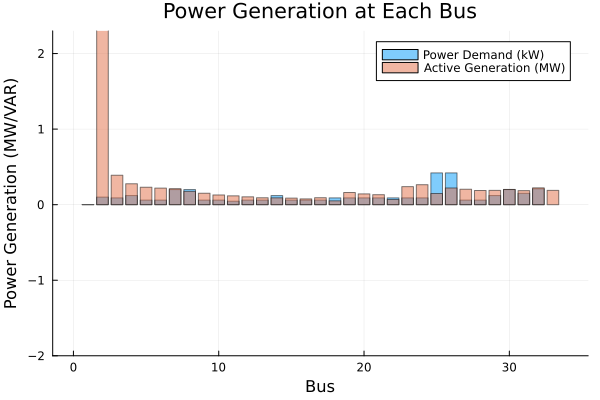

In [7]:
# bar(network_data[:, Symbol("P (kW)")] ./1000 , title="Power Demand at Each Bus", xlabel="Bus", label="Power Demand (kW)", alpha=0.5)
# bar!(consumption_at_bus, title="Power Consumption at Each Bus", xlabel="Bus", label="Power Consumption (kW)", alpha=0.5)
# bar!(PG_values, title="Power Balance at Each Bus", xlabel="Bus", label="Power Generation (kW)", alpha=0.5, ylim=(-2, 2.3),

bar(network_data[:, Symbol("P (kW)")] ./1000 , title="Power Demand at Each Bus", xlabel="Bus", label="Power Demand (kW)", alpha=0.5)
# bar!(consumption_at_bus, title="Power Generation at Each Bus", xlabel="Bus", label="Power Consumption", alpha=0.5)
bar!(PG_values, title="Power Generation at Each Bus", xlabel="Bus", label="Active Generation (MW)", alpha=0.5, ylabel="Power Generation (MW/VAR)", ylim=(-2, 2.3))

In [131]:
max_flows = network_data[:, Symbol("Maximum line capacity (active power [KW])")] ./ 1000

32-element Vector{Float64}:
 4.6
 4.1
 2.9
 2.9
 2.9
 1.5
 1.05
 1.05
 1.05
 1.05
 ⋮
 0.5
 1.5
 1.5
 1.5
 1.5
 1.5
 0.5
 0.5
 0.1

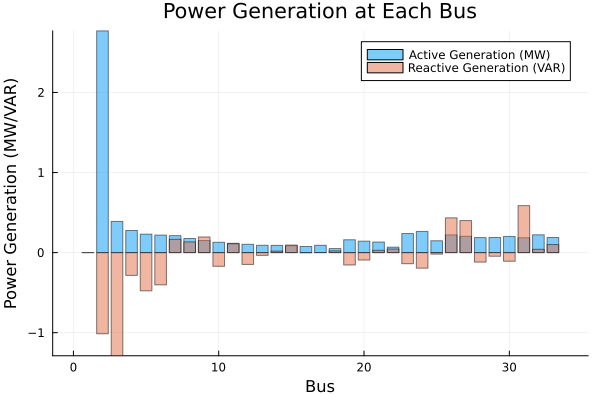

In [132]:
bar(PG_values, title="Power Generation at Each Bus", xlabel="Bus", label="Active Generation (MW)", alpha=0.5, ylabel="Power Generation (MW/VAR)")
bar!(QG_values, title="Power Generation at Each Bus", xlabel="Bus", label="Reactive Generation (VAR)", alpha=0.5)


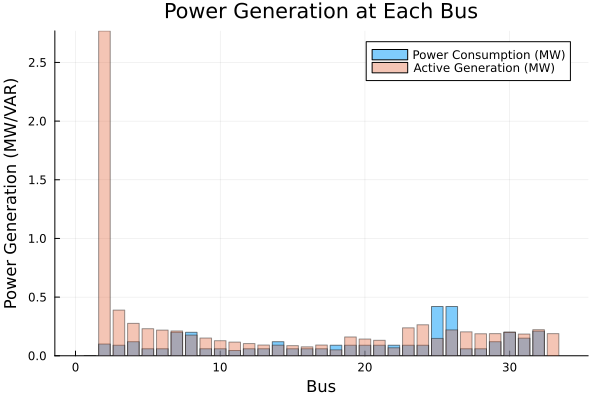

In [115]:
bar(network_data[:, Symbol("P (kW)")] ./1000 , title="Power Demand at Each Bus", xlabel="Bus", label="Power Consumption (MW)", alpha=0.5)
bar!(PG_values, title="Power Generation at Each Bus", xlabel="Bus", label="Active Generation (MW)", alpha=0.4, ylabel="Power Generation (MW/VAR)")

# imported_power_at_bus = [sum(PG_values[k] for k in buses if network_data[k, Symbol("From bus")] == i) for i in buses]


In [13]:
function create_hc_model_robust(network_data, PD_min, PD_max, QD_min, QD_max)
    model = Model(Gurobi.Optimizer)

    # Variables
    @variable(model, PG[buses] >= 0)  # Active power generation of PV
    @variable(model, QG[buses])  # Reactive power generation of PV
    @variable(model, -0.1 <= ΔV[buses] <= 0.1)  # Voltage magnitude deviation
    @variable(model, Δθ[buses])  # Voltage angle deviation
    @variable(model, PL[lines])  # Active power flow
    @variable(model, QL[lines])  # Reactive power flow
    @variable(model, PM)  # Active power exchange with upstream grid
    @variable(model, QM)  # Reactive power exchange with upstream grid
    @variable(model, q)  # Total PV generation

    # Objective function
    @objective(model, Max, q)  # Maximize total PV generation
    @constraint(model, q <= sum(PG[i] for i in buses))
    # Constraints
    # Power flow equations
    for l in lines
        i, j = network_data[l, Symbol("From bus")], network_data[l, Symbol("To bus")]
        r, x = network_data[l, Symbol("R (Ω)")], network_data[l, Symbol("X (Ω)")]
        g, b = r / (r^2 + x^2), -x / (r^2 + x^2)
        @constraint(model, PL[l] == g * (1 + ΔV[i]) * (ΔV[i] - ΔV[j]) - b * (Δθ[i] - Δθ[j]))
        @constraint(model, QL[l] == -b * (1 + ΔV[i]) * (ΔV[i] - ΔV[j]) - g * (Δθ[i] - Δθ[j]))
    end

    # Power balance constraints with uncertainty
    for i in buses
        @constraint(model, 
            (i == 1 ? PM : 0) + 
            sum(PL[l] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(PL[l] for l in lines if network_data[l, Symbol("From bus")] == i) + 
            PG[i] >= sum(PD_min[l] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Lower bound on active power demand
        )
        @constraint(model, 
            (i == 1 ? PM : 0) + 
            sum(PL[l] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(PL[l] for l in lines if network_data[l, Symbol("From bus")] == i) + 
            PG[i] <= sum(PD_max[l] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Lower bound on active power demand
        )
        @constraint(model, 
            (i == 1 ? QM : 0) + 
            sum(QL[l] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(QL[l] for l in lines if network_data[l, Symbol("From bus")] == i) + 
            QG[i] >= sum(QD_min[l] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Lower bound on active power demand
        )
        @constraint(model, 
            (i == 1 ? QM : 0) + 
            sum(QL[l] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(QL[l] for l in lines if network_data[l, Symbol("From bus")] == i) + 
            QG[i] <= sum(QD_max[l] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Lower bound on active power demand
        )
    end

    @constraint(model, PG[1] == 0)  
    @constraint(model, QG[1] == 0)

    # Voltage and line capacity constraints
    @constraint(model, -4.6 .<= PM .<= 4.6)  # Active power exchange limits with upstream grid
    @constraint(model, -4.6 .<= QM .<= 4.6)  # Reactive power exchange limits with upstream grid
    for l in lines
        active_max_flow = network_data[l, Symbol("Maximum line capacity (active power [KW])")] / 1000  # Convert to MW
        reactive_max_flow = network_data[l, Symbol("Maximum line capacity (reactive power [KVAR])")] / 1000  # Convert to MVAR
        @constraint(model, -active_max_flow <= PL[l] <= active_max_flow)
        @constraint(model, -reactive_max_flow <= QL[l] <= reactive_max_flow)
    end

    return model
end

function optimize_robust(network_data)
    # Define uncertainty sets
    PD_min = [0.8 * p for p in network_data[:, Symbol("P (kW)")]]
    PD_max = [1.2 * p for p in network_data[:, Symbol("P (kW)")]]
    QD_min = [0.8 * q for q in network_data[:, Symbol("Q (kW)")]]
    QD_max = [1.2 * q for q in network_data[:, Symbol("Q (kW)")]]
    
    model = create_hc_model_robust(network_data, PD_min, PD_max, QD_min, QD_max)
    optimize!(model)
    
    return model
end

function display_robust_results(model)
    # Store all solution values
    PG_values = value.(model[:PG])
    QG_values = value.(model[:QG])
    ΔV_values = value.(model[:ΔV])
    Δθ_values = value.(model[:Δθ])
    PL_values = value.(model[:PL])
    QL_values = value.(model[:QL])
    PM_value = value(model[:PM])
    QM_value = value(model[:QM])

    # Convert DenseAxisArray to regular arrays
    PG_values_array = collect(PG_values)
    QG_values_array = collect(QG_values)
    ΔV_values_array = collect(ΔV_values)
    Δθ_values_array = collect(Δθ_values)
    PL_values_array = collect(PL_values)
    QL_values_array = collect(QL_values)

    # Create dataframes to display the results
    bus_results = DataFrame(Bus = buses, PG = PG_values_array, QG = QG_values_array, ΔV = ΔV_values_array, Δθ = Δθ_values_array)
    line_results = DataFrame(Line = lines, PL = PL_values_array, QL = QL_values_array)

    # Display the results
    println("\nUpstream Grid Exchange:")
    println("PM: ", PM_value)
    println("QM: ", QM_value)
    println("Total PV capacity: ", sum(PG_values_array))

    println("Bus Results:")
    println(bus_results)
    println("\nLine Results:")
    println(line_results)
end

display_robust_results (generic function with 1 method)

In [14]:
robust = optimize_robust(network_data)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-18
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 201 rows, 265 columns and 560 nonzeros
Model fingerprint: 0x86fe1fee
Model has 64 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [3e-01, 9e+00]
  QLMatrix range   [3e-01, 9e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 5e+00]
  RHS range        [8e-03, 7e-01]
Presolve removed 103 rows and 37 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 141 rows and 135 columns
Presolve time: 0.01s
Presolved: 307 rows, 191 columns, 940 nonzeros
Presolved model has 61 bilinear constraint(s)
Variable types: 191 continuous, 0 integer (0 binary)
Found he

A JuMP Model
├ solver: Gurobi
├ objective_sense: MAX_SENSE
│ └ objective_function_type: VariableRef
├ num_variables: 199
├ num_constraints: 364
│ ├ AffExpr in MOI.EqualTo{Float64}: 2
│ ├ AffExpr in MOI.GreaterThan{Float64}: 66
│ ├ AffExpr in MOI.LessThan{Float64}: 67
│ ├ AffExpr in MOI.Interval{Float64}: 66
│ ├ QuadExpr in MOI.EqualTo{Float64}: 64
│ ├ VariableRef in MOI.GreaterThan{Float64}: 66
│ └ VariableRef in MOI.LessThan{Float64}: 33
└ Names registered in the model
  └ :PG, :PL, :PM, :QG, :QL, :QM, :q, :ΔV, :Δθ

In [12]:
robust_PG_values = Array(value.(robust[:PG]))
robust_QG_values = Array(value.(robust[:QG]));
robust_consumption_at_bus = [value.(robust[:PL])[l] for l in lines for bus in buses if network_data[l, Symbol("To bus")] == bus];

MathOptInterface.ResultIndexBoundsError{MathOptInterface.VariablePrimal}: Result index of attribute MathOptInterface.VariablePrimal(1) out of bounds. There are currently 0 solution(s) in the model.

In [11]:
bar(network_data[:, Symbol("P (kW)")] ./1000 , title="Power Demand at Each Bus", xlabel="Bus", label="Power Demand (kW)", alpha=0.5)
bar!(robust_consumption_at_bus, title="Power Generation at Each Bus", xlabel="Bus", label="Power Consumption", alpha=0.5)
bar!(robust_PG_values, title="Power Generation at Each Bus", xlabel="Bus", label="Active Generation (MW)", alpha=0.5, ylabel="Power Generation (MW/VAR)", ylim=(-2, 2.3))

# bar!(robust_QG_values, title="Power Generation at Each Bus", xlabel="Bus", label="Reactive Generation (VAR)", alpha=0.5)
# bar!(PG_values, title="Power Generation at Each Bus", xlabel="Bus", label="Active Generation (MW)", alpha=0.4, ylabel="Power Generation (MW/VAR)")


UndefVarError: UndefVarError: `robust_consumption_at_bus` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [156]:
mean(robust_PG_values[2])

2.8435982310506223

# Sparse

In [49]:
function create_hc_model_robust_sparse(network_data, PD_min, PD_max, QD_min, QD_max, k_sparse)
    model = Model(Gurobi.Optimizer)

    # Variables
    @variable(model, PG[buses] >= 0)  # Active power generation of PV
    @variable(model, open_bg[buses], Bin)  # Reactive power generation of PV
    @variable(model, QG[buses])  # Reactive power generation of PV
    @variable(model, ΔV[buses])  # Voltage magnitude deviation
    @variable(model, Δθ[buses])  # Voltage angle deviation
    @variable(model, PL[lines])  # Active power flow
    @variable(model, QL[lines])  # Reactive power flow
    @variable(model, PM)  # Active power exchange with upstream grid
    @variable(model, QM)  # Reactive power exchange with upstream grid

    # Objective function
    @objective(model, Max, sum(PG))  # Maximize total PV generation

    # Constraints
    # Power flow equations
    for l in lines
        i, j = network_data[l, Symbol("From bus")], network_data[l, Symbol("To bus")]
        r, x = network_data[l, Symbol("R (Ω)")], network_data[l, Symbol("X (Ω)")]
        g, b = r / (r^2 + x^2), -x / (r^2 + x^2)
        @constraint(model, PL[l] == g * (1 + ΔV[i]) * (ΔV[i] - ΔV[j]) - b * (Δθ[i] - Δθ[j]))
        @constraint(model, QL[l] == -b * (1 + ΔV[i]) * (ΔV[i] - ΔV[j]) - g * (Δθ[i] - Δθ[j]))
    end

    # Power balance constraints with uncertainty
    for i in buses
        @constraint(model, 
            (i == 1 ? PM : 0) + 
            sum(PL[l] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(PL[l] for l in lines if network_data[l, Symbol("From bus")] == i) + 
            PG[i] >= sum(PD_min[l] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Lower bound on active power demand
        )
        @constraint(model, 
            (i == 1 ? PM : 0) + 
            sum(PL[l] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(PL[l] for l in lines if network_data[l, Symbol("From bus")] == i) + 
            PG[i] <= sum(PD_max[l] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Lower bound on active power demand
        )
        @constraint(model, 
            (i == 1 ? QM : 0) + 
            sum(QL[l] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(QL[l] for l in lines if network_data[l, Symbol("From bus")] == i) + 
            QG[i] >= sum(QD_min[l] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Lower bound on active power demand
        )
        @constraint(model, 
            (i == 1 ? QM : 0) + 
            sum(QL[l] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(QL[l] for l in lines if network_data[l, Symbol("From bus")] == i) + 
            QG[i] <= sum(QD_max[l] for l in lines if network_data[l, Symbol("To bus")] == i) / 1000  # Lower bound on active power demand
        )
    end

    @constraint(model, PG[1] == 0)  
    @constraint(model, QG[1] == 0)

    # sparsity
    for i in buses
        @constraint(model, PG[i] <= 10e9 * open_bg[i])
        @constraint(model, QG[i] <= 10e9 * open_bg[i])
        @constraint(model, QG[i] >= -10e9 * open_bg[i])
    end

    @constraint(model, sum(open_bg) <= k_sparse)

    # Voltage and line capacity constraints
    # @constraint(model, -4.6 .<= PM .<= 4.6)  # Active power exchange limits with upstream grid
    # @constraint(model, -9 .<= QM .<= 9)  # Reactive power exchange limits with upstream grid
    # for l in lines
    #     active_max_flow = network_data[l, Symbol("Maximum line capacity (active power [KW])")] / 1000  # Convert to MW
    #     reactive_max_flow = network_data[l, Symbol("Maximum line capacity (reactive power [KVAR])")] / 1000  # Convert to MVAR
    #     @constraint(model, -active_max_flow <= PL[l] <= active_max_flow)
    #     @constraint(model, -reactive_max_flow <= QL[l] <= reactive_max_flow)
    # end

    return model
end

function optimize_robust_sparse(network_data, k_sparse)
    # Define uncertainty sets
    PD_min = [0.8 * p for p in network_data[:, Symbol("P (kW)")]]
    PD_max = [1.2 * p for p in network_data[:, Symbol("P (kW)")]]
    QD_min = [0.8 * q for q in network_data[:, Symbol("Q (kW)")]]
    QD_max = [1.2 * q for q in network_data[:, Symbol("Q (kW)")]]
    
    model = create_hc_model_robust_sparse(network_data, PD_min, PD_max, QD_min, QD_max, k_sparse)
    optimize!(model)
    
    return model
end

function display_robust_results_sparse(model)
    # Store all solution values
    PG_values = value.(model[:PG])
    QG_values = value.(model[:QG])
    ΔV_values = value.(model[:ΔV])
    Δθ_values = value.(model[:Δθ])
    PL_values = value.(model[:PL])
    QL_values = value.(model[:QL])
    PM_value = value(model[:PM])
    QM_value = value(model[:QM])

    # Convert DenseAxisArray to regular arrays
    PG_values_array = collect(PG_values)
    QG_values_array = collect(QG_values)
    ΔV_values_array = collect(ΔV_values)
    Δθ_values_array = collect(Δθ_values)
    PL_values_array = collect(PL_values)
    QL_values_array = collect(QL_values)

    # Create dataframes to display the results
    bus_results = DataFrame(Bus = buses, PG = PG_values_array, QG = QG_values_array, ΔV = ΔV_values_array, Δθ = Δθ_values_array)
    line_results = DataFrame(Line = lines, PL = PL_values_array, QL = QL_values_array)

    # Display the results
    println("\nUpstream Grid Exchange:")
    println("PM: ", PM_value)
    println("QM: ", QM_value)
    println("Total PV capacity: ", sum(PG_values_array))

    println("Bus Results:")
    println(bus_results)
    println("\nLine Results:")
    println(line_results)
end

display_robust_results_sparse (generic function with 1 method)

In [44]:
sum(value.(robust[:PG]))

1.0347077671143105e7

In [ ]:
robust = optimize_robust_sparse(network_data, 2)
robust_PG_values = Array(value.(robust[:PG]))
robust_QG_values = Array(value.(robust[:QG]));
robust_consumption_at_bus = [value.(robust[:PL])[l] for l in lines for bus in buses if network_data[l, Symbol("To bus")] == bus];

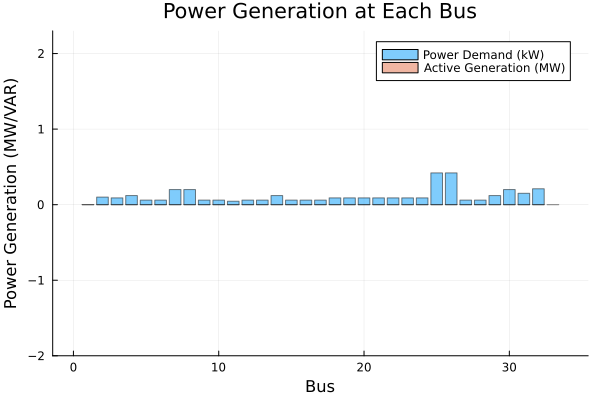

In [51]:
bar(network_data[:, Symbol("P (kW)")] ./1000 , title="Power Demand at Each Bus", xlabel="Bus", label="Power Demand (kW)", alpha=0.5)
# bar!(robust_consumption_at_bus, title="Power Generation at Each Bus", xlabel="Bus", label="Power Consumption", alpha=0.5)
bar!(robust_PG_values, title="Power Generation at Each Bus", xlabel="Bus", label="Active Generation (MW)", alpha=0.5, ylabel="Power Generation (MW/VAR)", ylim=(-2, 2.3))


# Stochastic Paper

In [159]:
import Pkg; Pkg.add("Ipopt")

   Resolving package versions...
   Installed MUMPS_seq_jll ────── v500.700.300+0
   Installed SPRAL_jll ────────── v2024.5.8+0
   Installed Hwloc_jll ────────── v2.11.2+1
   Installed ASL_jll ──────────── v0.1.3+0
   Installed OpenBLAS32_jll ───── v0.3.28+3
   Installed Ipopt ────────────── v1.7.0
   Installed Ipopt_jll ────────── v300.1400.1600+0
   Installed MutableArithmetics ─ v1.6.0
   Installed METIS_jll ────────── v5.1.2+1
   Installed MathOptInterface ─── v1.34.0
    Updating `C:\Users\noe\.julia\environments\Julia_v1_11_1__IAI_v3_2_2\Project.toml`
  [b6b21f68] + Ipopt v1.7.0
    Updating `C:\Users\noe\.julia\environments\Julia_v1_11_1__IAI_v3_2_2\Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.5.0
  [523fee87] + CodecBzip2 v0.8.4
  [944b1d66] + CodecZlib v0.7.6
  [bbf7d656] + CommonSubexpressions v0.3.1
  [163ba53b] + DiffResults v1.1.0
  [b552c78f] + DiffRules v1.15.1
  [f6369f11] + ForwardDiff v0.10.38
  [b6b21f68] + Ipopt v1.7.0
  [1914dd2f] + MacroTools v0.5.13
  [b8f2778

In [160]:
using Ipopt

# Lossless power flow model
function create_hc_model(load_data, solar_cf, network_data, daily_Qdemand)
    model = Model(Ipopt.Optimizer)

    # Variables
    @variable(model, CPV[buses] >= 0)  # PV capacity at each bus
    @variable(model, -1 <= ΔV[buses, 1:T] <= 1)  # Voltage magnitude deviation
    @variable(model, Δθ[buses, 1:T])  # Voltage angle deviation
    @variable(model, PL[lines, 1:T])  # Active power flow
    @variable(model, QL[lines, 1:T])  # Reactive power flow
    @variable(model, PM[1:T])  # Active power exchange with upstream grid
    @variable(model, QM[1:T])  # Reactive power exchange with upstream grid

    # Objective function
    @objective(model, Max, sum(CPV))

    # Constraints
    # Power flow equations
    for t in 1:T, l in lines
        i, j = network_data[l, Symbol("From bus")], network_data[l, Symbol("To bus")]
        r, x = network_data[l, Symbol("R (Ω)")], network_data[l, Symbol("X (Ω)")]
        g, b = r / (r^2 + x^2), -x / (r^2 + x^2)
        @constraint(model, PL[l,t] == g * (1 + ΔV[i,t]) * (ΔV[i,t] - ΔV[j,t]) - b * (Δθ[i,t] - Δθ[j,t]))
        @constraint(model, QL[l,t] == -b * (1 + ΔV[i,t]) * (ΔV[i,t] - ΔV[j,t]) - g * (Δθ[i,t] - Δθ[j,t]))
    end

    # Power balance constraints
    for t in 1:T, i in buses
        first_row_index = findfirst(l -> network_data[l, Symbol("To bus")] == i, lines)
        if first_row_index !== nothing
            Q_value = network_data[first_row_index, Symbol("Q (kW)")]
        else
            Q_value = 0.0  # or some default value
        end
        @constraint(model, 
            (i == 1 ? PM[t] : 0) + 
            sum(PL[l,t] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(PL[l,t] for l in lines if network_data[l, Symbol("From bus")] == i) + 
            solar_cf[t, i+1] * CPV[i] == 
            (i == 1 ? 0 : load_data[t, i+1])
        )
        @constraint(model, 
            (i == 1 ? QM[t] : 0) + 
            sum(QL[l,t] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(QL[l,t] for l in lines if network_data[l, Symbol("From bus")] == i) +
            solar_cf[t, i+1] * CPV[i] == 
            (i == 1 ? 0 : Q_value) * daily_Qdemand[t] / 1000 
        )
    end

    @constraint(model, CPV[1] == 0)  

    # Voltage and line capacity constraints
    for t in 1:T
        @constraint(model, -0.1 .<= ΔV[:, t] .<= 0.1)  # Voltage deviation limits
        @constraint(model, -4.6 .<= PM[t] .<= 4.6)  # Active power exchange limits with upstream grid
        for l in lines
            active_max_flow = network_data[l, Symbol("Maximum line capacity (active power [KW])")] / 1000  # Convert to MW
            reactive_max_flow = network_data[l, Symbol("Maximum line capacity (reactive power [KVAR])")] / 1000  # Convert to MVAR
            @constraint(model, -active_max_flow <= PL[l, t] <= active_max_flow)
            @constraint(model, -reactive_max_flow <= QL[l, t] <= reactive_max_flow)
        end
    end

    for t in nam:T-nam
        @constraint(model, (1 / nam) * sum(PM[t+h] - PM[t+h-nam] for h in 1:nam) <= NLDI_max) # Net load deviation index
    end  

    return model
end


function main(daily_Qdemand)
    model = create_hc_model(load_data, solar_cf, network_data, daily_Qdemand)
    optimize!(model)

    # Print results
    println("Optimal PV capacity: ", value.(model[:CPV]))
    println("Total PV capacity: ", sum(value.(model[:CPV])))
end

main (generic function with 1 method)

In [570]:
using Ipopt

# Lossless power flow model
function create_hc_model_aug(load_data, solar_cf, network_data)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)

    # Variables
    @variable(model, PG[buses] >= 0)  # PV capacity at each bus
    @variable(model, QG[buses])  # Reactive power generation of PV
    @variable(model, -1 <= ΔV[buses, 1:T] <= 1)  # Voltage magnitude deviation
    @variable(model, Δθ[buses, 1:T])  # Voltage angle deviation
    @variable(model, PL[lines, 1:T])  # Active power flow
    @variable(model, QL[lines, 1:T])  # Reactive power flow
    @variable(model, PM[1:T])  # Active power exchange with upstream grid
    @variable(model, QM[1:T])  # Reactive power exchange with upstream grid

    # Objective function
    @objective(model, Max, sum(PG))

    # Constraints
    # Power flow equations
    for t in 1:T, l in lines
        i, j = network_data[l, Symbol("From bus")], network_data[l, Symbol("To bus")]
        r, x = network_data[l, Symbol("R (Ω)")], network_data[l, Symbol("X (Ω)")]
        g, b = r / (r^2 + x^2), -x / (r^2 + x^2)
        @constraint(model, PL[l,t] == g * (1 + ΔV[i,t]) * (ΔV[i,t] - ΔV[j,t]) - b * (Δθ[i,t] - Δθ[j,t]))
        @constraint(model, QL[l,t] == -b * (1 + ΔV[i,t]) * (ΔV[i,t] - ΔV[j,t]) - g * (Δθ[i,t] - Δθ[j,t]))
    end

    # Power balance constraints
    for t in 1:T, i in buses
        first_row_index = findfirst(l -> network_data[l, Symbol("To bus")] == i, lines)
        if first_row_index !== nothing
            Q_value = network_data[first_row_index, Symbol("Q (kW)")]
        else
            Q_value = 0.0  # or some default value
        end
        @constraint(model, 
            (i == 1 ? PM[t] : 0) + 
            sum(PL[l,t] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(PL[l,t] for l in lines if network_data[l, Symbol("From bus")] == i) + 
            solar_cf[t, i+1] * PG[i] == load_data[i, 1, t] / 1000 # Convert kW to MW
        )
        @constraint(model, 
            (i == 1 ? QM[t] : 0) + 
            sum(QL[l,t] for l in lines if network_data[l, Symbol("To bus")] == i) - 
            sum(QL[l,t] for l in lines if network_data[l, Symbol("From bus")] == i) +
            solar_cf[t, i+1] * QG[i] == load_data[i, 2, t] / 1000 
        )
    end

    @constraint(model, PG[1] == 0)  
    @constraint(model, QG[1] == 0)  

    # # Voltage and line capacity constraints
    # for t in 1:T
    #     @constraint(model, -0.1 .<= ΔV[:, t] .<= 0.1)  # Voltage deviation limits
    #     @constraint(model, -46 .<= PM[t] .<= 46)  # Active power exchange limits with upstream grid
    #     @constraint(model, -46 .<= QM[t] .<= 46)  # Reactive power exchange limits with upstream grid
    #     for l in lines
    #         active_max_flow = network_data[l, Symbol("Maximum line capacity (active power [KW])")] / 1000  # Convert to MW
    #         reactive_max_flow = network_data[l, Symbol("Maximum line capacity (reactive power [KVAR])")] / 1000  # Convert to MVAR
    #         @constraint(model, -active_max_flow <= PL[l, t] <= active_max_flow)
    #         @constraint(model, -reactive_max_flow <= QL[l, t] <= reactive_max_flow)
    #     end
    # end

    # for t in nam:T-nam
    #     @constraint(model, (1 / nam) * sum(PM[t+h] - PM[t+h-nam] for h in 1:nam) <= NLDI_max) # Net load deviation index
    # end  

    return model
end


function main_aug(load_data, solar_cf, network_data)
    model = create_hc_model_aug(load_data, solar_cf, network_data)
    optimize!(model)

    # Print results
    println("Optimal PV capacity: ", value.(model[:PG]))
    println("Total PV capacity: ", sum(value.(model[:PG])))
    return model
end

main_aug (generic function with 2 methods)

In [571]:
# solar_cf_2 = ones(24, 34) .* 0.5;
for bus in 1:34
    peak = 1 + rand(Normal(0, 0.01))
    solar_cf_2[:, bus] .= 1
end


In [ ]:
aug_network_data_load = network_data[:, ["P (kW)", "Q (kW)"]]
n_bus = length(buses)
load_aug = zeros(Float64, n_bus, 2, T)

for t in 1:T
    for row in 2:n_bus
        # data_time_series[row, 1, t] = data[row, 1]  # Keep the "Row" column constant
        load_aug[row, 1, t] = sum([network_data[l, Symbol("P (kW)")] for l in lines if network_data[l, Symbol("To bus")] == row + 1], init=0.0) .* rand(Normal(1.0, 0.01))  # P (kW)
        load_aug[row, 2, t] = sum([network_data[l, Symbol("Q (kW)")] for l in lines if network_data[l, Symbol("To bus")] == row + 1], init=0.0).* rand(Normal(1.0, 0.01))  # Q (kW)
    end
end

stoch_aug = main_aug(load_aug, solar_cf_2, network_data)

In [515]:
println("Optimal PV capacity: ", value.(stoch_aug[:PM]))

Optimal PV capacity: [-4.296835919826769, -4.30733024318507, -4.30892866026295, -4.272264082296821, -4.3158959031002055, -4.277495312131081, -4.2941537353168355, -4.296482131974766, -4.3005430679863315, -4.290282308390174, -4.293353283592474, -4.300113663518525, -4.282256703557101, -4.318801787370924, -4.293478445384253, -4.288353217043695, -4.294751089399968, -4.2952330867035835, -4.296572953508824, -4.3082976577203, -4.309369152094919, -4.288187131895271, -4.290719029420822, -4.293910381407615]


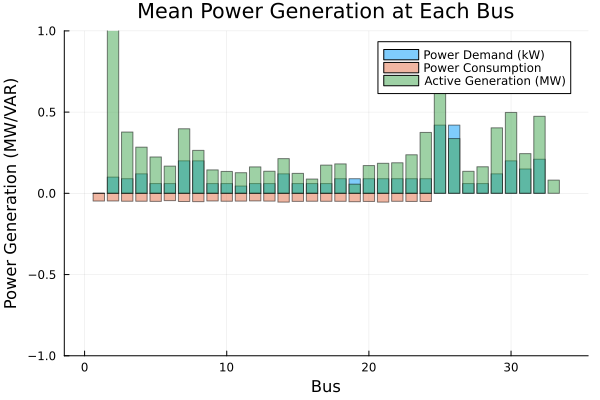

In [516]:
consumption_at_bus = [mean(value.(stoch_aug[:PL])[l,:]) for l in lines for bus in buses if network_data[l, Symbol("To bus")] == bus] .- [mean(value.(stoch_aug[:PL])[l,:]) for l in lines for bus in buses if network_data[l, Symbol("From bus")] == bus];


bar(network_data[:, Symbol("P (kW)")] ./1000 , title="Power Demand at Each Bus", xlabel="Bus", label="Power Demand (kW)", alpha=0.5)
bar!(incoming .- outgoing, title="Mean Power Generation at Each Bus", xlabel="Bus", label="Power Consumption", alpha=0.5)

bar!(Array(value.(stoch_aug[:PG])), title="Mean Power Generation at Each Bus", xlabel="Bus", label="Active Generation (MW)", alpha=0.5, ylabel="Power Generation (MW/VAR)", ylim=(-1, 1))
# value.(stoch_aug[:PG])

In [517]:
hourly_grid_demand = [sum(load_aug[:,1,t]) for t in 1:24] /1000
hourly_grid_pull = value.(stoch_aug[:PM]);

Maximum difference:2.552208383521659e-8


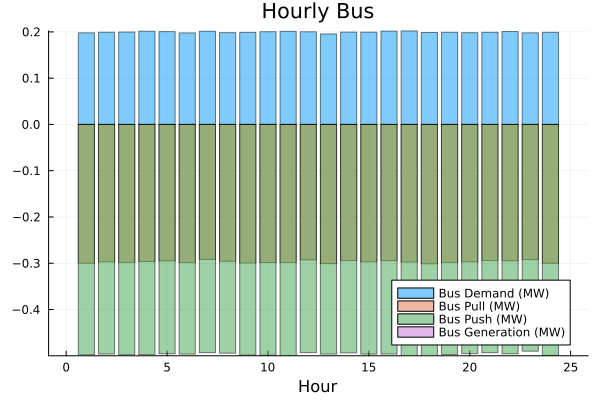

In [530]:
bus = 30

consumed = load_aug[bus, 1, :] ./ 1000
incoming = [sum(value.(stoch_aug[:PL])[l,t] for l in lines if network_data[l, Symbol("To bus")] == bus) for t in 1:T]
outgoing = [sum(value.(stoch_aug[:PL])[l,t] for l in lines if network_data[l, Symbol("From bus")] == bus) for t in 1:T]

produced = value.(stoch_aug[:PG])[bus] .* solar_cf_2[1:T,bus]

# sanity check:
println("Maximum difference:", maximum(incoming - outgoing + produced - consumed))

bar(consumed, title="Hourly Bus", xlabel="Hour", label="Bus Demand (MW)", alpha=0.5)
bar!(incoming, xlabel="Hour", label="Bus Pull (MW)", alpha=0.5)
bar!(outgoing, xlabel="Hour", label="Bus Push (MW)", alpha=0.5)
bar!(produced, xlabel="Hour", label="Bus Generation (MW)", alpha=0.5)


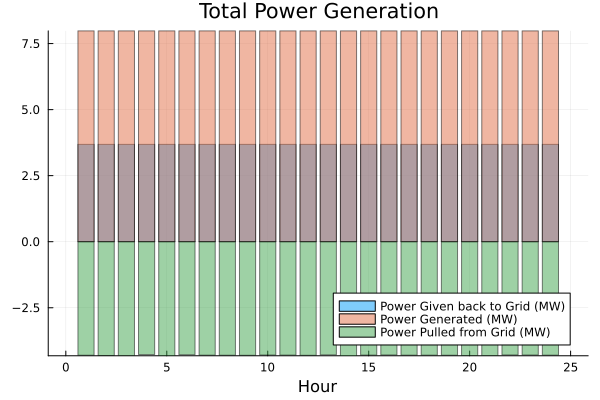

In [513]:
given_t = - transpose(sum(Array(value.(stoch_aug[:PL])), dims=1))
daily_solar = Matrix(solar_cf_2[1:T, 1 .+ buses])
prod_t = Array(daily_solar) * Array(value.(stoch_aug[:PG]))
pulled_t = Array(value.(stoch_aug[:PM]))

# bar(given_t, title="Total Power Generation", xlabel="Hour", label="Power Given back to Grid (MW)", alpha=0.5)
bar(hourly_grid_demand, title="Total Power Generation", xlabel="Hour", label="Power Given back to Grid (MW)", alpha=0.5)
bar!(prod_t, title="Total Power Generation", xlabel="Hour", label="Power Generated (MW)", alpha=0.5)
bar!(pulled_t, title="Total Power Generation", xlabel="Hour", label="Power Pulled from Grid (MW)", alpha=0.5)

In [ ]:
incoming = [sum(mean(Array(value.(stoch_aug[:PL])), dims=2)[network_data[:, Symbol("To bus")] .== b]) for b in buses]
outgoing = [sum(mean(Array(value.(stoch_aug[:PL])), dims=2)[network_data[:, Symbol("From bus")] .== b]) for b in buses]
consumption = incoming .- outgoing;

In [423]:
incoming_PL = [mean(value.(stoch_aug[:PL])[l,:]) for l in lines for bus in buses if network_data[l, Symbol("To bus")] == bus]
outgoing_PL = [mean(value.(stoch_aug[:PL])[l,:]) for l in lines for bus in buses if network_data[l, Symbol("From bus")] == bus]
# outgoing_PL = [sum([value.(stoch_aug[:PL])[l, :] for l in lines if network_data[l, Symbol("From bus")] == bus], init=0.0) for bus in buses]
# difference_PL = incoming_PL .- outgoing_PL
# 
println("Difference between incoming and outgoing PL at each bus:")
println(incoming_PL)
println(outgoing_PL)

Difference between incoming and outgoing PL at each bus:
[-4.332104037268981, -1.4064487601575655, -0.8104838886980422, -0.6553550842568892, -0.49324681630520034, -0.24593081899336236, -0.2372420176711604, -0.27166811511039407, -0.19587915968116784, -0.1318844386824797, -0.0749918710629862, -0.03954654184101545, -0.009686223454826478, -0.03842125063054159, -0.0191649199541048, -0.006323433466442599, 0.020398867668870262, 0.07869236264335072, 0.04670586751106764, 0.026763717867403582, 0.02702233376103784, -0.26825634549877003, -0.08971415240263238, 0.1176708855223058, -0.09596267541686283, -0.3168601745972486, -0.21697896529085303, -0.11685765466315136, -0.06596123065624619, -0.07286948769591879, -0.05106524465861952, -0.04115171593728128]
[-4.332104037268981, -1.4064487601575655, -0.8104838886980422, -0.6553550842568892, -0.49324681630520034, -0.24593081899336236, -0.2372420176711604, -0.27166811511039407, -0.19587915968116784, -0.1318844386824797, -0.0749918710629862, -0.0395465418410

In [212]:
nam = 5                 # Number of averaged measures (filter window size)
NLDI_max = 0.2 * 4.6    # Predefined upper limit

mu_PD = 0.8     # Mean daily demand
sigma_PD = 0.4  # Standard deviation

# Generate daily demand using Gaussian distribution
daily_Qdemand = clamp.(rand(Normal(mu_PD, sigma_PD), T), 0.0, 1.0)

main(daily_Qdemand)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:    16001
Number of nonzeros in inequality constraint Jacobian.:     2502
Number of nonzeros in Lagrangian Hessian.............:     3072

Total number of variables............................:     3201
                     variables with only lower bounds:       33
                variables with lower and upper bounds:      792
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3121
Total number of inequality c